In [1]:
import cftime
import fsspec
import numpy as np
import xarray as xr
import yaml
import matplotlib.pyplot as plt
import matplotlib
import string
from datetime import timedelta

import vcm
plt.rcParams['figure.dpi'] = 200

In [2]:
with open('run_urls.yaml') as f:
    runs = yaml.safe_load(f)

### Open pre-computed diagnostics to plot zonal mean biases

In [3]:
urls_long = {
    "baseline": runs['baseline-35day']['url'],
    "ML-physics, seed-5": runs['prog-35day-seed5']['url'],
    "ML-physics, seed-7": runs['prog-35day-seed7']['url'],
    "nudge-to-fine": runs['n2f-35day']['url'],
}
verif_url = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'

In [4]:
fs = fsspec.filesystem('gs')
reduced_diags = []
for name, url in urls_long.items():
    tmp = vcm.open_remote_nc(fs, url+'_diagnostics/diags.nc')
    reduced_diags.append(tmp.assign_coords(run=name))
reduced_diags = xr.concat(reduced_diags, dim='run')
reduced_diags = reduced_diags.assign_coords(pressure=reduced_diags.pressure/100)
reduced_diags['pressure'].attrs['units'] = 'hPa'
reduced_diags['specific_humidity_pressure_level_zonal_bias'] = 1000 * reduced_diags['specific_humidity_pressure_level_zonal_bias']
reduced_diags['specific_humidity_pressure_level_zonal_bias'].attrs['units'] = 'g/kg'
reduced_diags['relative_humidity_pressure_level_zonal_bias'] = 100 * reduced_diags['relative_humidity_pressure_level_zonal_bias']
reduced_diags['relative_humidity_pressure_level_zonal_bias'].attrs['units'] = '%'

In [5]:
for variable in ['air_temperature', 'specific_humidity', 'relative_humidity']:
    reduced_diags[f'{variable}_pressure_level_zonal_bias'].attrs['long_name'] = variable.replace('_', ' ') + ' bias'

In [6]:
reduced_diags_only_seed5 = reduced_diags.sel(run=['baseline', 'ML-physics, seed-5', 'nudge-to-fine'])
reduced_diags_only_seed5 = reduced_diags_only_seed5.assign_coords(run=['baseline', 'ML-physics', 'nudge-to-fine'])

In [7]:
value = 'total_precip_to_surface_zonal_mean_value'
err = 'total_precip_to_surface_zonal_mean_bias'
verif = (reduced_diags[value].isel(run=0) - reduced_diags[err].isel(run=0)).assign_coords(run='fine-grid')
hov = xr.concat([reduced_diags[value], verif], dim='run')


In [8]:
def make_nice_labels(fg, title_suffices=None, title_fontsize=10):
    fg.set_titles(template='{value}')
    fg.axes.flat[0].set_xticks(np.arange(-80, 91, 40))
    fg.axes.flat[0].set_xticklabels(['80S', '40S', 'EQ', '40N', '80N'])
    i = 0
    for letter, ax in zip(string.ascii_lowercase, fg.axes.flat):
        title = ax.get_title()
        if title_suffices is not None:
            title_suffix = title_suffices[i]
        else:
            title_suffix = ''
        ax.set_title(f'{letter}) {title}{title_suffix}', fontsize=title_fontsize)
        ax.set_xlabel('')
        i += 1

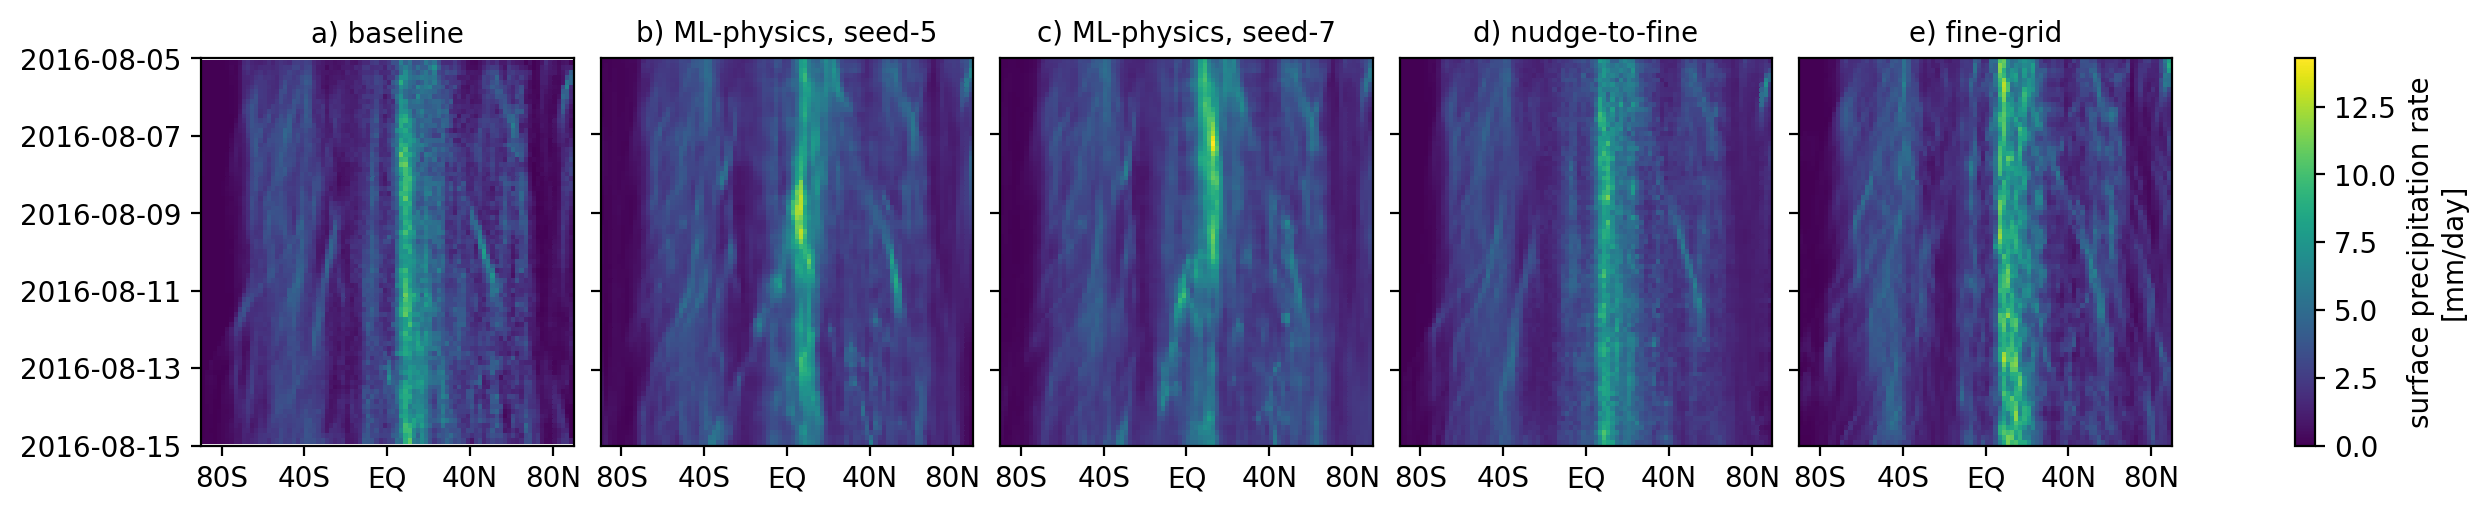

In [9]:
plotme = hov.sel(time=slice('2016-08-05', '2016-08-14T21:00:00'))
plotme.attrs['long_name'] = 'surface precipitation rate'
fg = plotme.plot(col='run', y='time', yincrease=False)
fg.fig.set_size_inches((13.5, 2.8))
fg.axes.flat[0].set_yticks([cftime.datetime(2016,8,d) for d in [5, 7, 9, 11, 13, 15]])
fg.axes.flat[0].set_ylabel('')
make_nice_labels(fg)

Text(0.5, 1.0, 'f) time-mean')

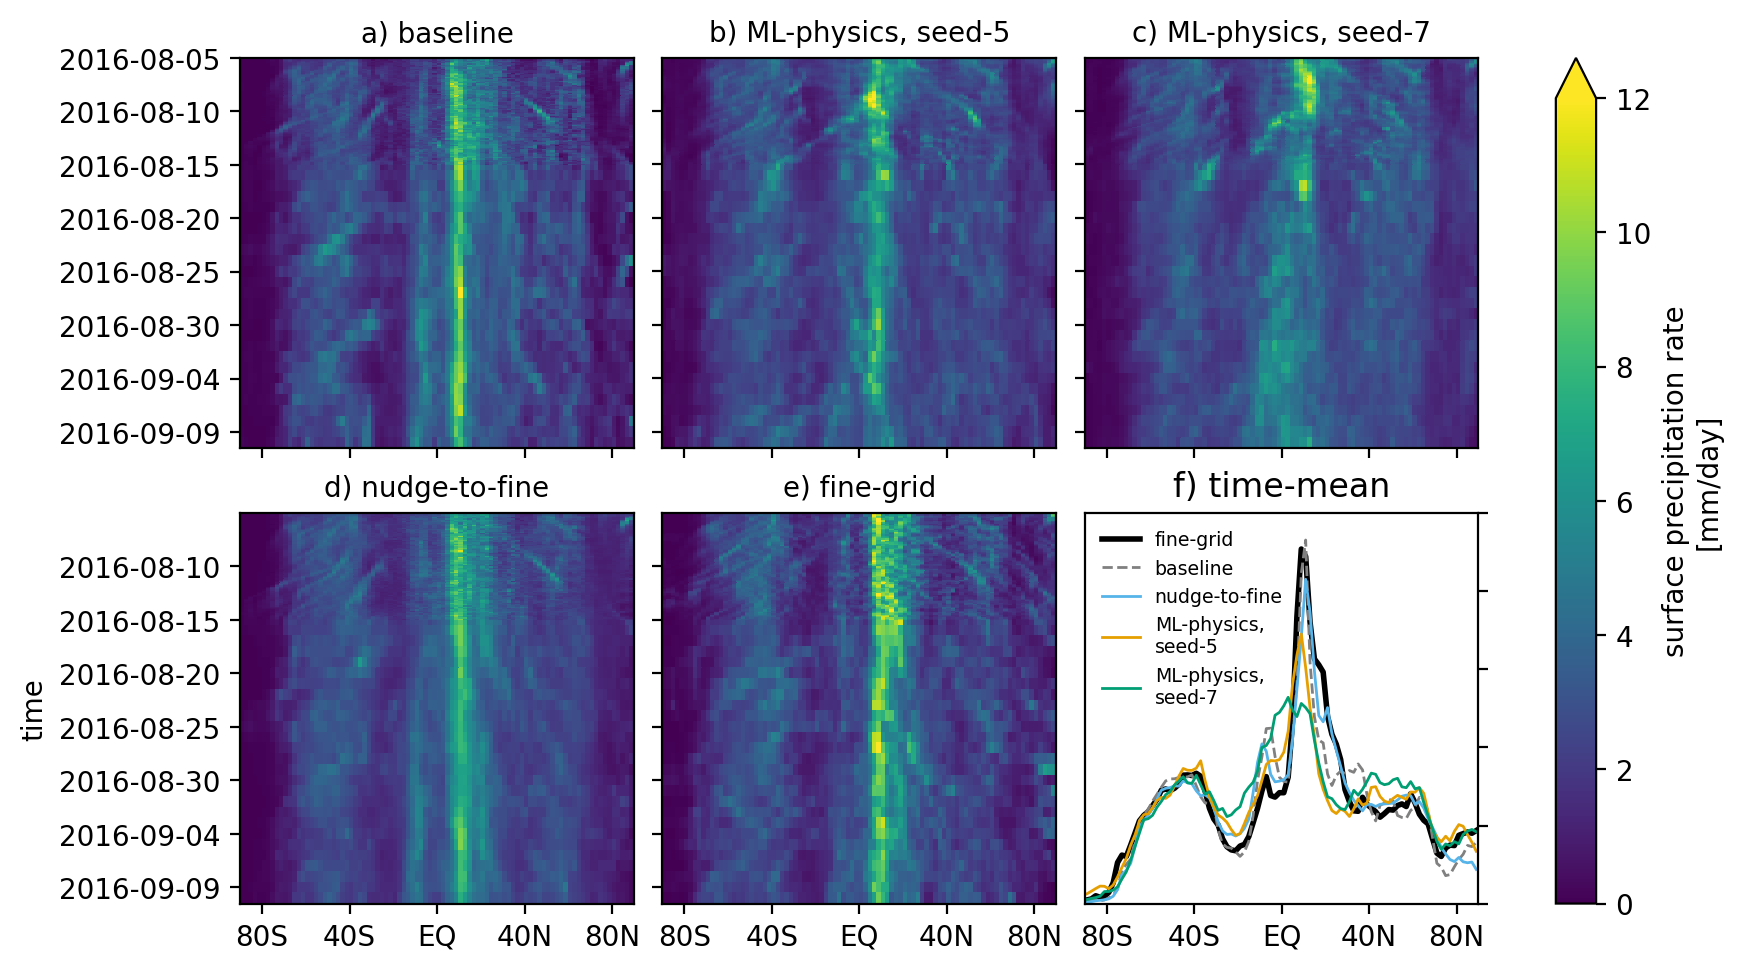

In [10]:
plotme = hov
plotme.attrs['long_name'] = 'surface precipitation rate'
fg = plotme.plot(col='run', y='time', yincrease=False, col_wrap=3, vmin=0, vmax=12)
fg.fig.set_size_inches((9, 5))
fg.axes.flat[0].set_yticks([cftime.datetime(2016,8,5) + td for td in [timedelta(days=x) for x in range(0, 36, 5)]])
fg.axes.flat[0].set_ylabel('')
make_nice_labels(fg)

ax = fg.fig.axes[5]
time_mean_zonal_mean_precip = hov.sel(time=slice('2016-08-15', None)).mean('time')
colors = {'baseline': 'grey', 'fine-grid': 'black', 'ML-physcs, seed-5': 'tab:green'}
linestyles = {'baseline': '--'}
linewidths = {'baseline': 1, 'fine-grid': 2}
for run in time_mean_zonal_mean_precip.run.values[[4, 0, 3, 1, 2]]:
    kwargs = {'color': colors.get(run), 'linestyle': linestyles.get(run), 'linewidth': linewidths.get(run, 1)}
    time_mean_zonal_mean_precip.sel(run=run).plot(ax=ax, label=run.replace(' ', '\n'), **kwargs)
ax.get_shared_y_axes().remove(ax)
ax.set_ylim([0, 10])
ax.set_visible(True)
yticker = matplotlib.axis.Ticker()
yloc = matplotlib.ticker.AutoLocator()
yfmt = matplotlib.ticker.ScalarFormatter()
ax.yaxis.major = yticker
ax.yaxis.set_major_locator(yloc)
ax.yaxis.set_major_formatter(yfmt)
ax.yaxis.tick_right()
ax.yaxis.set_ticks([0, 2, 4, 6, 8, 10])
ax.legend(fontsize=6.8, frameon=False, loc=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('f) time-mean')

#fg.fig.sharey=False

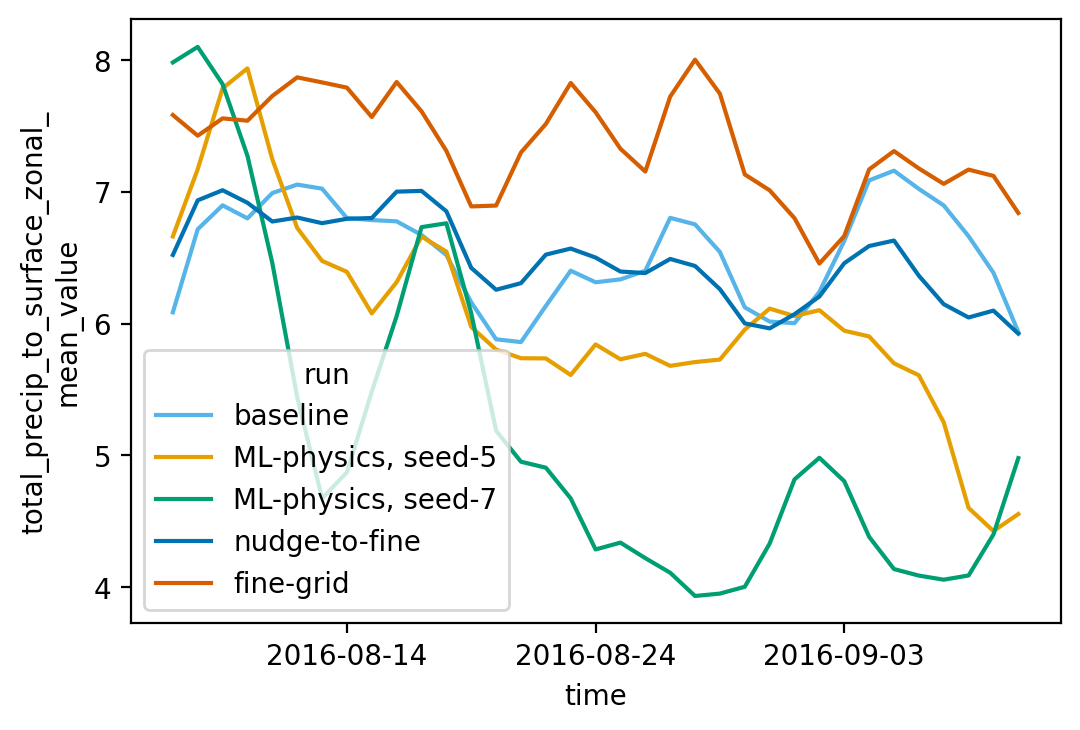

In [11]:
itcz_precip = hov.sel(latitude=slice(5, 15)).mean('latitude')
itcz_precip = itcz_precip.resample(time='1D').mean('time').rolling(time=3).mean('time')
itcz_precip.plot(hue='run')

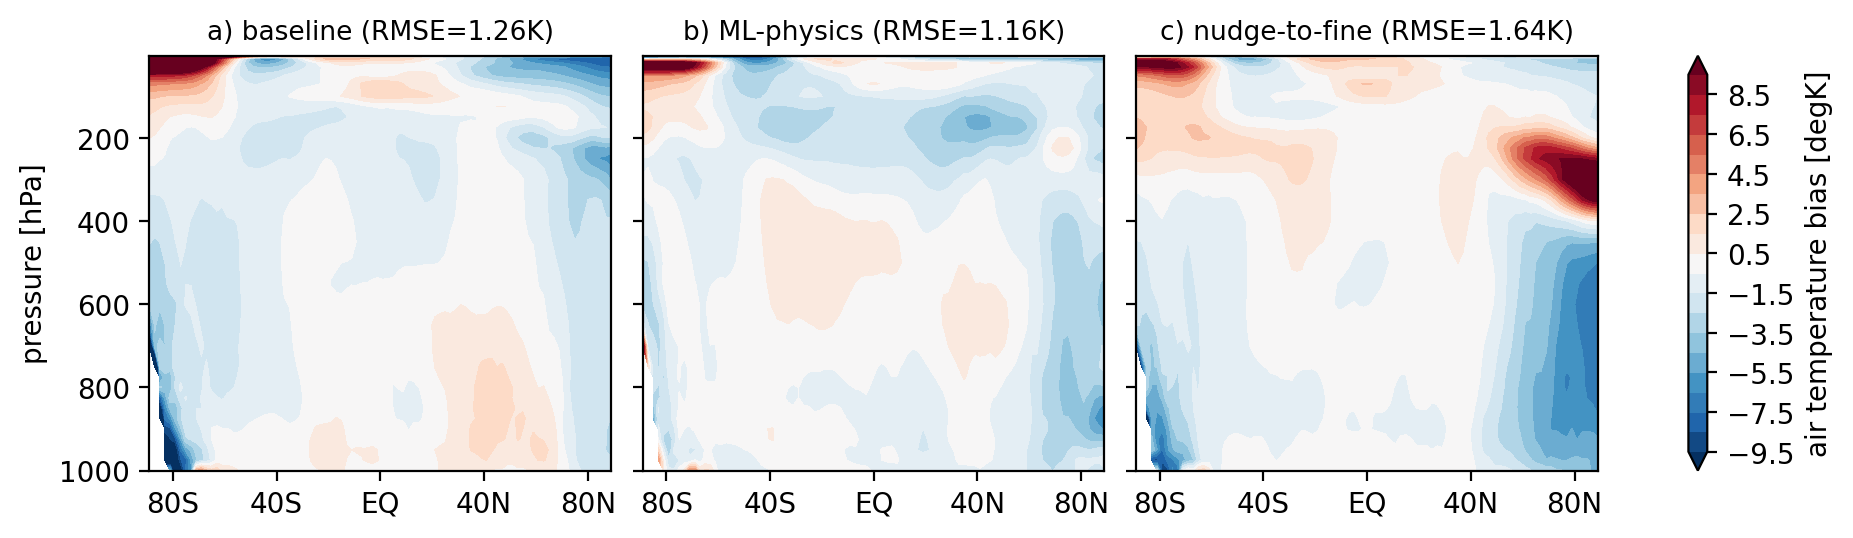

In [41]:
da = reduced_diags_only_seed5.air_temperature_pressure_level_zonal_bias
weights = np.cos(np.deg2rad(da.latitude))*da.pressure
da_rmse = np.sqrt((da**2).weighted(weights).mean(['latitude', 'pressure']))
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-9.5, vmax=9.5, levels=20, cmap='RdBu_r')
make_nice_labels(fg, title_suffices=[f' (RMSE={x:.2f}K)' for x in da_rmse.values], title_fontsize=9.5)

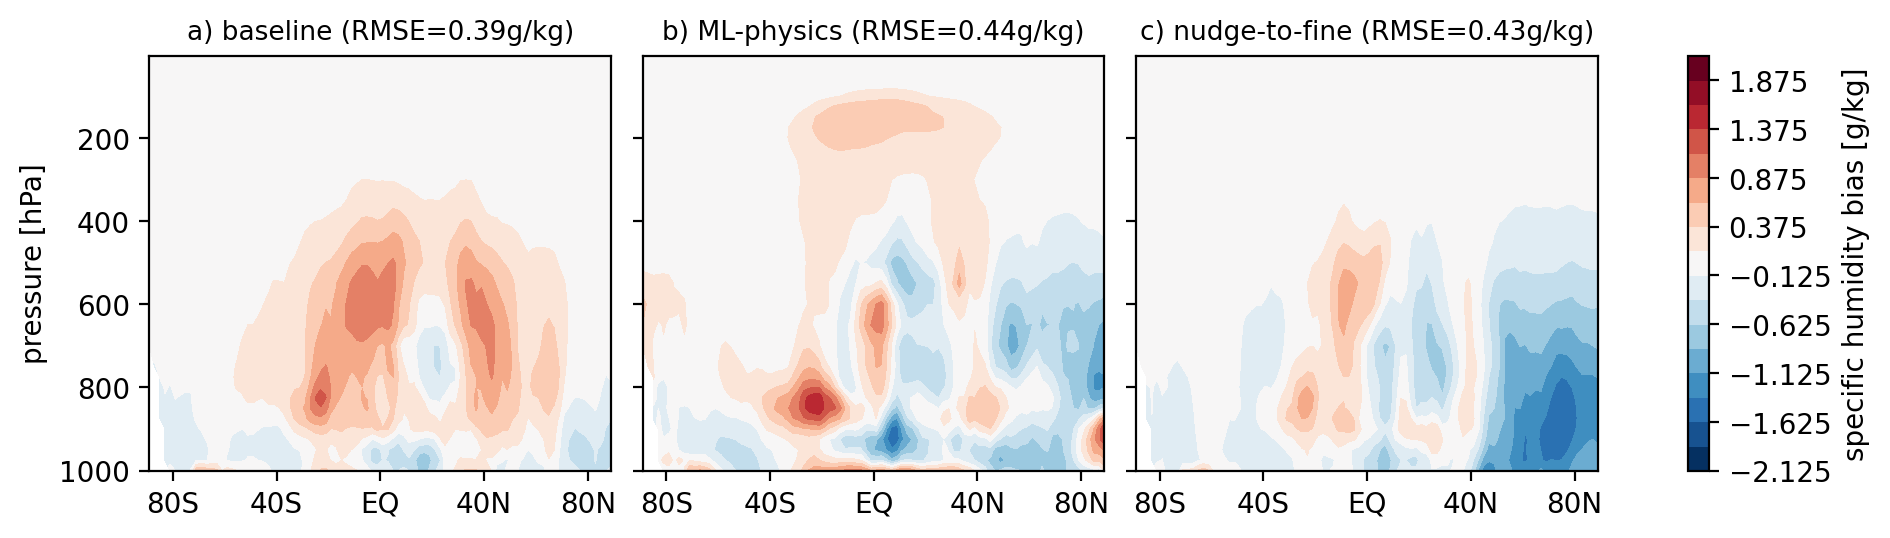

In [13]:
da = reduced_diags_only_seed5.specific_humidity_pressure_level_zonal_bias
weights = np.cos(np.deg2rad(da.latitude))*da.pressure
da_rmse = np.sqrt((da**2).weighted(weights).mean(['latitude', 'pressure']))
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-2.125, vmax=2.125, levels=18, cmap='RdBu_r')
make_nice_labels(fg, title_suffices=[f' (RMSE={x:.2f}g/kg)' for x in da_rmse.values], title_fontsize=9.5)

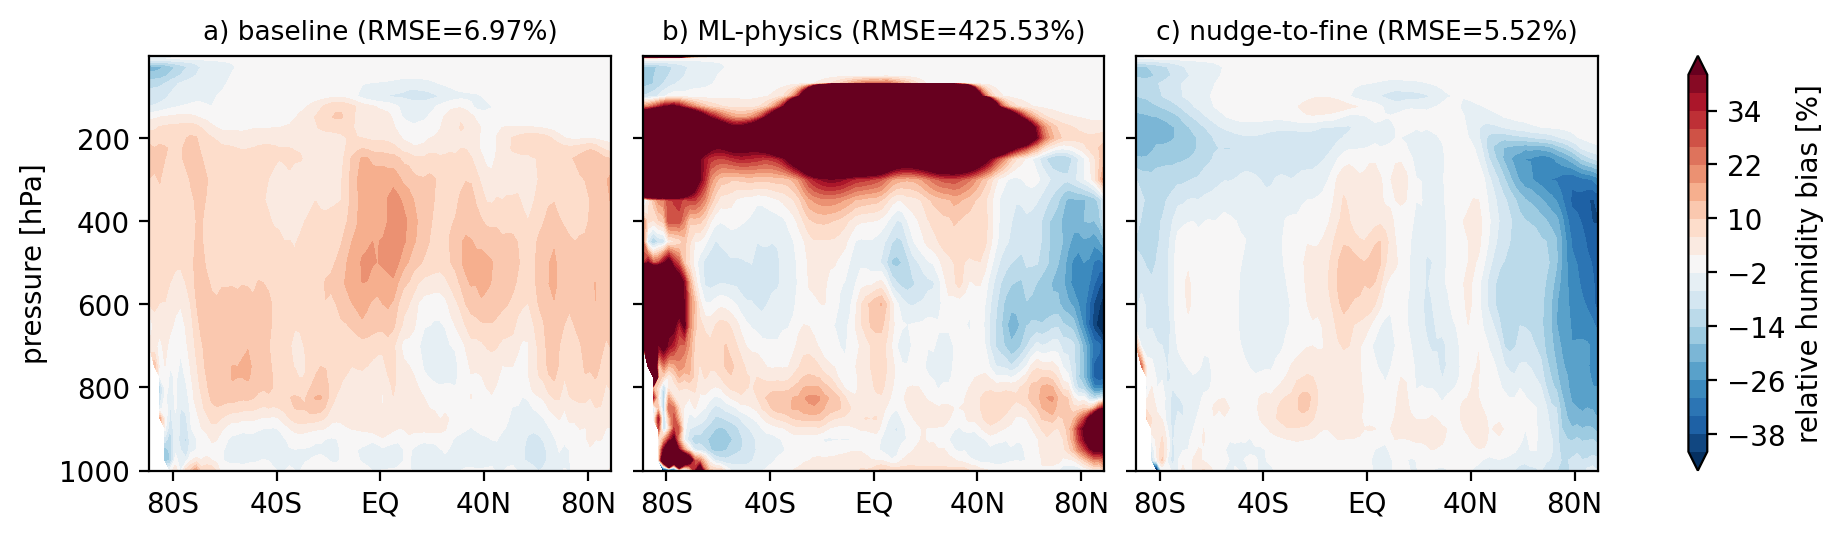

In [25]:
da = reduced_diags_only_seed5.relative_humidity_pressure_level_zonal_bias
weights = np.cos(np.deg2rad(da.latitude))*da.pressure
da_rmse = np.sqrt((da**2).weighted(weights).mean(['latitude', 'pressure']))
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-42, vmax=42, levels=22, cmap='RdBu_r', extend='both')
make_nice_labels(fg, title_suffices=[f' (RMSE={x:.2f}%)' for x in da_rmse.values], title_fontsize=9.5)

### Compute RH RMSE below 350hPa and equatorward of 60°

In [42]:
da = reduced_diags_only_seed5.relative_humidity_pressure_level_zonal_bias
weights = np.cos(np.deg2rad(da.latitude))*da.pressure
weights[abs(weights.latitude)>60, :] = 0.0
weights[:, weights.pressure<350] = 0.0
da_rmse = np.sqrt((da**2).weighted(weights).mean(['latitude', 'pressure']))
print(da_rmse)

<xarray.DataArray 'relative_humidity_pressure_level_zonal_bias' (run: 3)>
array([6.97746407, 6.01199009, 3.75861999])
Coordinates:
  * run      (run) <U13 'baseline' 'ML-physics' 'nudge-to-fine'


In [43]:
(6.86 - 5.83) / 6.86

0.1501457725947522

In [44]:
(6.98 - 6.01) / 6.98

0.13896848137535825

In [39]:
da = reduced_diags_only_seed5.relative_humidity_pressure_level_zonal_bias
weights = np.cos(np.deg2rad(da.latitude))*da.pressure
weights[abs(weights.latitude)>60, :] = 0.0
weights[:, weights.pressure<350] = 0.0
da_rmse = da.weighted(weights).mean(['latitude', 'pressure'])
print(da_rmse)

<xarray.DataArray 'relative_humidity_pressure_level_zonal_bias' (run: 3)>
array([3.72623271, 1.43683307, 0.38793427])
Coordinates:
  * run      (run) <U13 'baseline' 'ML-physics' 'nudge-to-fine'
